In [50]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader # Gives easier dataset managment and creates mini batches
from torch.utils.data import Subset # Subset of a dataset at specified indices
import torchvision.datasets as datasets # Has standard datasets we can import in a nice and easy way
import torchvision.transforms as transforms # Transformations we can perform on our dataset
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

In [51]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [52]:
batch_size = 64
train_dataset = datasets.MNIST(
    root="dataset/",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_dataset = datasets.MNIST(
    root="dataset/",
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True
)

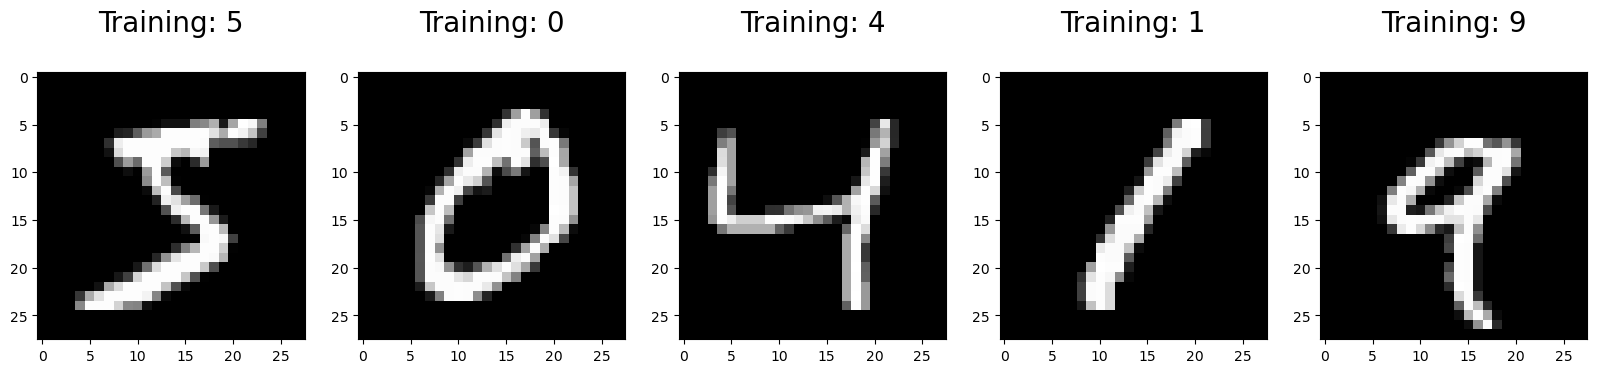

In [53]:
train_subset = Subset(train_dataset, list(range(0, 5)))
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(train_subset):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray) 
    plt.title('Training: %i\n' %int(label), fontsize=20)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 784 # 28x28 = 784, size of MNIST images (grayscale)
num_classes = 10
learning_rate = 0.001
num_epochs = 3

In [55]:
model = NN(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [57]:
writer = SummaryWriter()

for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape, 28x28->784
        # -1 will flatten all outer dimensions into one
        data = data.reshape(data.shape[0], -1)

        # forward propagation
        scores = model(data)
        loss = criterion(scores, targets)
        
        writer.add_scalar('Loss/train', loss.item(), epoch * len(train_loader) + batch_idx)

        # zero previous gradients
        optimizer.zero_grad()

        # back-propagation
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

Epoch: 0
Epoch: 1
Epoch: 2


In [8]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    model.train()

In [9]:
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Got 57586 / 60000 with accuracy 95.98
Got 9556 / 10000 with accuracy 95.56


In [48]:
from sklearn import metrics
import seaborn as sns

def visualize(cm):
    # using seaborn to visualize confusion matrix 
    print('confusion matrix visualization')
    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Confusion matrix'
    plt.title(all_sample_title, size = 15)


def confusion_matrix(loader, model):
    model.eval()
    predicted = []
    actual = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            
            predicted += predictions.cpu().numpy().tolist()
            actual += y.cpu().numpy().tolist()
    
    #print(predicted)
    #print(actual)
    cm = metrics.confusion_matrix(actual, predicted)
    print('Confusion matrix')
    print(cm)
    visualize(cm)

    model.train()

Confusion matrix
[[5810    0    9    2    6    7   36    6   40    7]
 [   1 6626   24    9    8    1    7   10   45   11]
 [  32   25 5679   22   34    4   27   58   67   10]
 [  14   20  104 5613    5  135   10   38  136   56]
 [  10   20   15    2 5540    2   54   13   22  164]
 [  31   16   15   44   22 5108   75   12   63   35]
 [  25    7    4    0   16   12 5837    1   16    0]
 [  10   21   35    1   28    8    1 6065   10   86]
 [  18   44   16   25   14   22   31   11 5629   41]
 [  18   17    0   35   70   19    3   66   42 5679]]
confusion matrix visualization


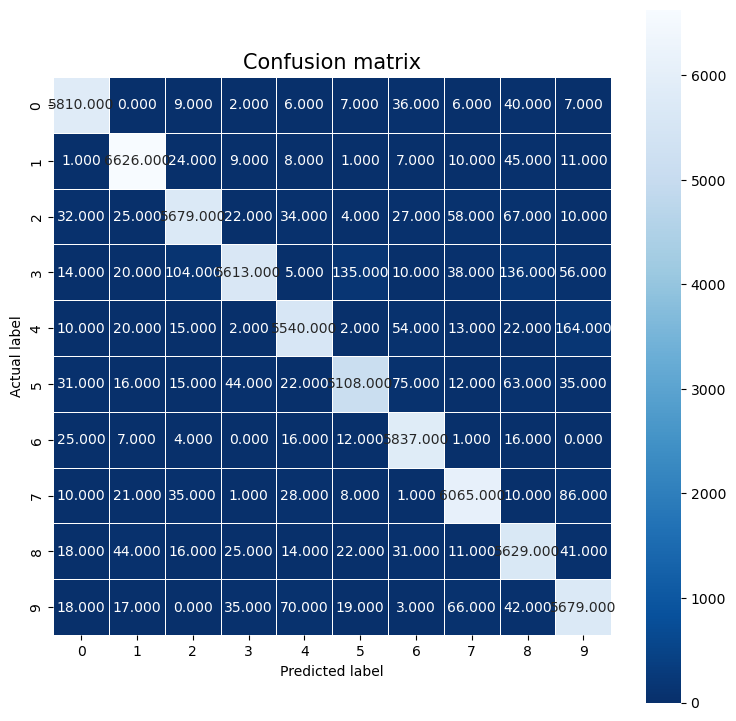

In [49]:
confusion_matrix(train_loader, model)